In [1]:
# General
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Natural language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Regular expression
import re

# Custom functions
from functions import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\atkat\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Load the data
---

In [2]:
DATA_PATH = '../data/quotebank_attr_2015-2020.json.bz2'
df = pd.read_json(DATA_PATH)
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_qid,gender,nationality,date_of_birth,ethnic_group,occupation,party,academic_degree,domains
0,2015-10-05-010038,At Neath Food Festival with a vegetarian platt...,Bethan Jenkins,[Q4897688],2015-10-05 05:00:00,1,"[[Bethan Jenkins, 0.8565], [None, 0.1435]]",[http://www.southwales-eveningpost.co.uk/Town-...,E,Q4897688,None,None,None,None,None,None,None,[southwales-eveningpost.co.uk]
1,2015-11-28-006688,"But if I had to choose my favourite recipe, it...",Trish Deseine,[Q7843986],2015-11-28 00:00:00,1,"[[Trish Deseine, 0.7664], [None, 0.1125], [Kei...",[http://www.irishexaminer.com/lifestyle/featur...,E,Q7843986,None,None,None,None,None,None,None,[irishexaminer.com]
2,2015-11-10-015422,"Children are learning about responsibility, te...",David Price,"[Q1176177, Q16063598, Q20804677, Q20973688, Q3...",2015-11-10 19:30:41,1,"[[David Price, 0.7849], [None, 0.2151]]",[http://news.ifas.ufl.edu/2015/11/ufifas-bok-t...,E,None,None,None,None,None,None,None,None,[ufl.edu]
3,2015-01-16-054273,Once we have added all the vegetables and stoc...,None,[],2015-01-16 11:40:11,4,"[[None, 0.6778], [Catherine O'Neill, 0.3222]]",[http://www.bromsgrovestandard.co.uk/2015/01/1...,E,None,None,None,None,None,None,None,None,"[bromsgrovestandard.co.uk, bromsgrovestandard...."
4,2015-02-20-089622,vegans in a steakhouse.,Jim Gaffigan,[Q2093638],2015-02-20 00:05:44,1,"[[Jim Gaffigan, 0.7894], [None, 0.2106]]",[http://unfspinnaker.com/expect-jim-gaffigans-...,E,Q2093638,[male],[United States of America],[+1966-07-07T00:00:00Z],None,"[screenwriter, film producer, television actor...",None,None,[unfspinnaker.com]


# 2. Preparation of the data
---

In [3]:
preprocess_dataframe(df)

In [4]:
def timestamp_to_datetime(date_str):
    """
    Convert the wikipedia timestamp to the datetime format.
    """
    match = re.findall('\d{4}-\d{2}-\d{2}', date_str)[0]
    match = re.split('-00', match, 1)[0]
    return pd.to_datetime(match, errors='coerce')

In [5]:
# Transform the timestamp format to the datetime format
df.date_of_birth = df.date_of_birth.apply(lambda list_date: timestamp_to_datetime(list_date[0]) if list_date != None else pd.NaT)

In [6]:
# Perform the sentiment analysis 
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['quotation'].apply(lambda quote: get_sentiment(analyzer, quote))

In [7]:
# Preprocess the gender feature
df.gender = df.gender.apply(lambda gender_list: gender_list[0] if gender_list != None else None)

# 3. Analysis
---

## 3.1. Gender
---

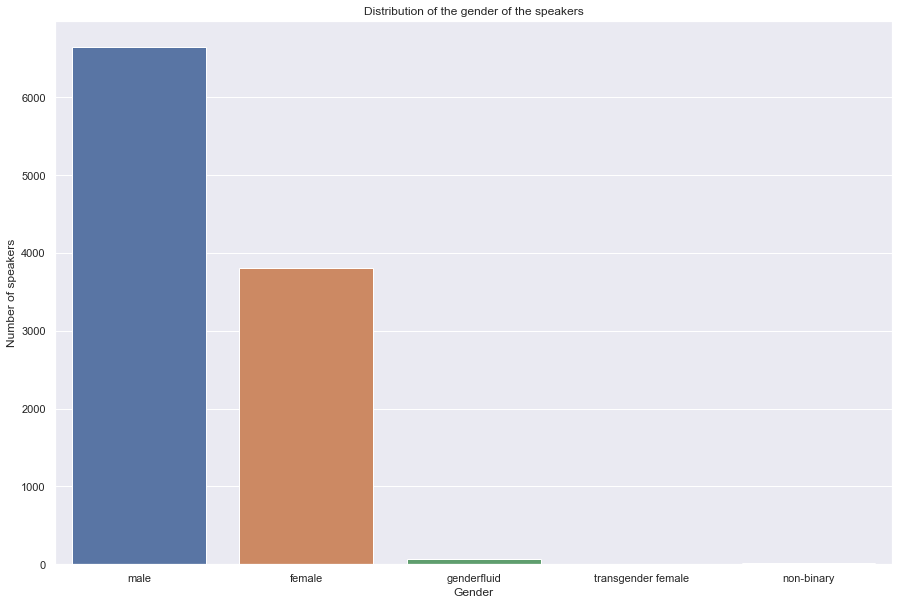

In [8]:
# Plot
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15, 10))
ax = sns.countplot(x='gender', data=df)
title = ax.set_title('Distribution of the gender of the speakers')
xlabel = ax.set_xlabel('Gender')
ylabel = ax.set_ylabel('Number of speakers')

It is quite clear that the male gender is dominating. The following are more robust for the male and female genders because they are more represented in our dataset.  

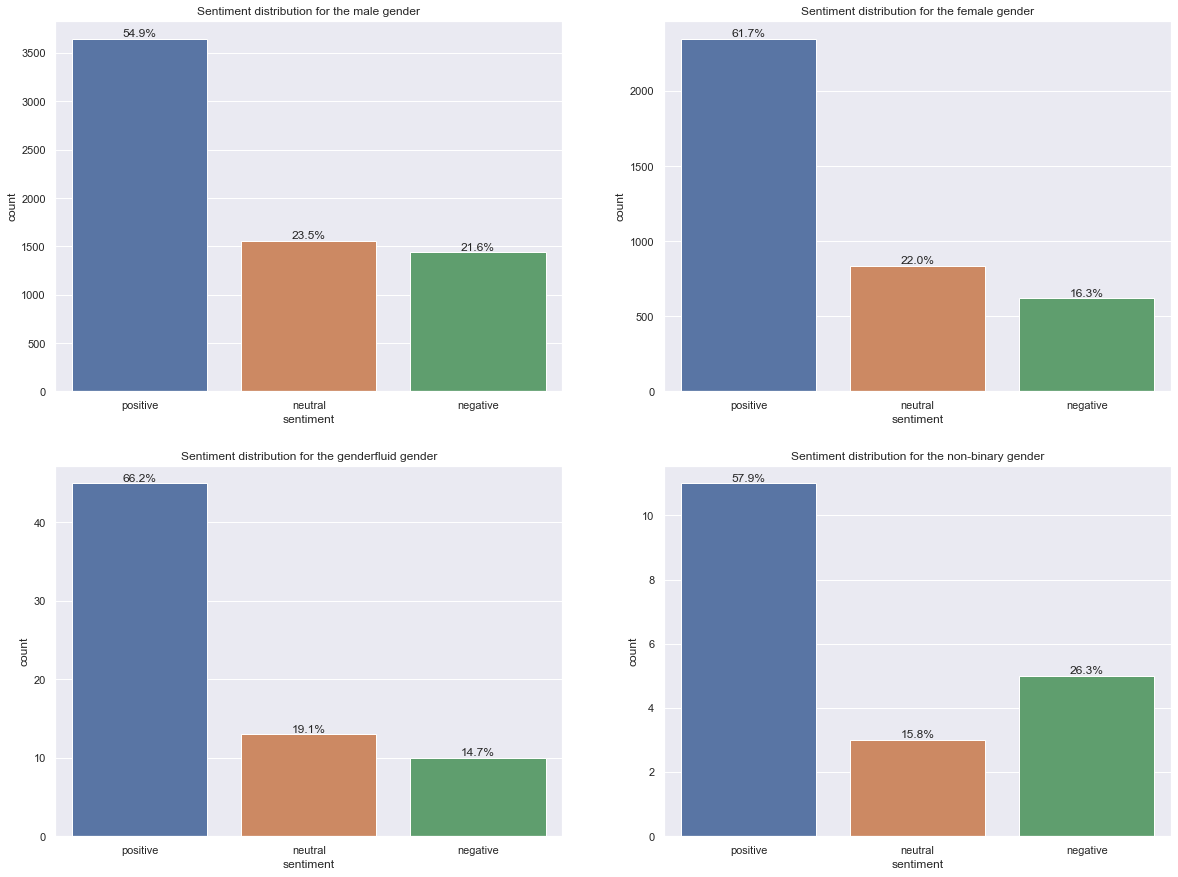

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
gender_list = df.gender.value_counts()[:4].index # Take the 4 more frequent genders
for ind, gender in enumerate(gender_list):
    ax = sns.countplot(ax = axes[ind // 2, ind % 2], x='sentiment', data=df[df.gender == gender], order=['positive', 'neutral', 'negative'])
    title = ax.set_title('Sentiment distribution for the ' + gender + ' gender')
    
    # Add percentages
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{h/(df.gender == gender).sum()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

We can observe that men tend to be less positive towards vegetarianism.

## Number of occurrences
---

- How do the quotations which appear multiple times in the articles contribute to the overall quotation distribution.